In [1]:

## Importing necessary header files
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold,SelectKBest,f_regression

from sklearn import metrics
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error,mean_absolute_error,accuracy_score
import seaborn as sb
from sklearn.model_selection import learning_curve, GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

import xgboost as xgb
from xgboost import plot_importance

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import pie, axis, show

!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim 

import pickle 

import warnings
warnings.filterwarnings("ignore")

C:\Users\megha\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

### Raw Datasets

In [4]:
art = pd.read_csv("./Raw_data_sample/ArticlesApril2017.csv")
com = pd.read_csv("./Raw_data_sample/CommentsApril2017.csv")

In [4]:
art.head()

,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,58def1347c459f24986d7c80,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...
1,NaN,58def3237c459f24986d7c84,823,By GAIL COLLINS,article,"And Now, the Dreaded Trump Curse","['United States Politics and Government', 'Tru...",3,OpEd,23,2017-04-01 00:23:58,Unknown,Meet the gang from under the bus.,The New York Times,Op-Ed,https://www.nytimes.com/2017/03/31/opinion/and...
2,NaN,58def9f57c459f24986d7c90,575,By THE EDITORIAL BOARD,article,Venezuela’s Descent Into Dictatorship,"['Venezuela', 'Politics and Government', 'Madu...",3,Editorial,22,2017-04-01 00:53:06,Unknown,A court ruling annulling the legislature’s aut...,The New York Times,Editorial,https://www.nytimes.com/2017/03/31/opinion/ven...
3,NaN,58defd317c459f24986d7c95,1374,By MICHAEL POWELL,article,Stain Permeates Basketball Blue Blood,"['Basketball (College)', 'University of North ...",3,Sports,1,2017-04-01 01:06:52,College Basketball,"For two decades, until 2013, North Carolina en...",The New York Times,News,https://www.nytimes.com/2017/03/31/sports/ncaa...
4,NaN,58df09b77c459f24986d7ca7,708,By DEB AMLEN,article,Taking Things for Granted,['Crossword Puzzles'],3,Games,0,2017-04-01 02:00:14,Unknown,In which Howard Barkin and Will Shortz teach u...,The New York Times,News,https://www.nytimes.com/2017/03/31/crosswords/...


In [5]:
com.head()

,approveDate,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,parentID,parentUserDisplayName,permID,picURL,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sharing,status,timespeople,trusted,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,inReplyTo,articleID,sectionName,newDesk,articleWordCount,printPage,typeOfMaterial
0,1491245186,This project makes me happy to be a 30+ year T...,22022598.0,22022598,<br/>,comment,1.491237e+09,1,False,0.0,NaN,22022598,https://graphics8.nytimes.com/images/apps/time...,2.0,NaN,0.0,NaN,0,approved,1.0,0.0,1491245186,Rob Gayle,46006296,"Riverside, CA",NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
1,1491188619,Stunning photos and reportage. Infuriating tha...,22017350.0,22017350,NaN,comment,1.491180e+09,1,False,0.0,NaN,22017350,https://graphics8.nytimes.com/images/apps/time...,1.0,NaN,0.0,NaN,0,approved,1.0,0.0,1491188619,Susan A.,29202761,<br/>,NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
2,1491188617,Brilliant work from conception to execution. I...,22017334.0,22017334,<br/>,comment,1.491179e+09,1,False,0.0,NaN,22017334,https://graphics8.nytimes.com/images/apps/time...,3.0,NaN,0.0,NaN,0,approved,1.0,0.0,1491188617,Meta,63944806,Raleigh NC,NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
3,1491167820,NYT reporters should provide a contributor's l...,22015913.0,22015913,<br/>,comment,1.491150e+09,1,False,0.0,NaN,22015913,https://graphics8.nytimes.com/images/apps/time...,7.0,NaN,2.0,NaN,0,approved,1.0,0.0,1491167820,Tom Wyrick,1266184,"Missouri, USA",NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
4,1491167815,Could only have been done in print. Stunning.,22015466.0,22015466,<br/>,comment,1.491147e+09,1,False,0.0,NaN,22015466,http://profile.ak.fbcdn.net/hprofile-ak-snc4/h...,5.0,NaN,0.0,NaN,0,approved,1.0,0.0,1491167815,Joe Sharkey,61121360,"Tucson, Arizona",NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News


### Processed Data

In [5]:
# Loading the datasets
Data_train = pd.read_csv("./Final_data/TRAIN_DATA.csv")
Data_test = pd.read_csv("./Final_data/VALIDATION_DATA.csv")


In [9]:
Data_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,commentID,createDate,articleWordCount,depth,recommendations,replyCount,userIDRC,editorsSelection,ratio_comment_article,word_count,comment,reporterReply,userReply,0_LDA,1_LDA,2_LDA,3_LDA,4_LDA,5_LDA,6_LDA,7_LDA,8_LDA,9_LDA,10_LDA,11_LDA,12_LDA,13_LDA,14_LDA,15_LDA,16_LDA,17_LDA,18_LDA,19_LDA,articleID,articleRelevance,Sentiment
0,0.082981,-0.097531,-0.022281,0.035595,0.002903,0.008946,-0.004116,0.016800,0.004000,-0.054189,0.077229,0.077173,-0.018401,0.005129,0.002620,-0.020919,0.067789,0.031618,0.013293,0.029003,-0.029955,0.036427,0.005118,-0.010949,-0.030049,0.014499,0.025284,0.013931,0.008188,-0.000378,21059310.0,9070.0,1254.0,1.0,17.0,0.0,0.000000,0.0,592.000000,327.0,1.0,0.0,0.0,0.015234,0.000000,0.001474,0.002076,0.000541,0.012121,0.006296,0.000000,0.000510,0.000000,0.000000,0.000207,0.108492,0.0,0.000400,0.000469,0.000320,0.000157,0.000000,0.001834,587575d295d0e0392607a033,0.035309,0.4767
1,0.080163,0.047493,-0.014904,0.005567,-0.004679,-0.010961,-0.000744,-0.006526,0.057172,0.030394,-0.031720,-0.003787,-0.021565,0.002246,0.014513,0.046155,0.060575,-0.040848,-0.047009,0.062050,0.005777,-0.013676,0.031962,0.024183,0.042047,0.013725,0.052387,0.009911,-0.017457,-0.009532,20991167.0,52691.0,1233.0,2.0,3.0,0.0,44.684211,0.0,12.523810,149.0,0.0,0.0,1.0,0.000000,0.000655,0.002676,0.000213,0.004868,0.000209,0.000000,0.000562,0.038849,0.001519,0.000933,0.003135,0.000254,0.0,0.001058,0.000990,0.001085,0.000253,0.000428,0.019422,586d000995d0e03926078eb2,-0.071916,0.8176
2,0.139329,0.048922,-0.002704,-0.020177,0.027447,0.016011,0.013575,0.007308,0.051769,0.078340,-0.020746,-0.062149,0.056916,-0.024390,-0.003366,-0.016006,-0.025657,0.057256,0.084533,0.011410,-0.024506,0.108592,0.007283,0.014737,0.063473,-0.039380,0.018769,0.057798,0.033112,-0.034020,21029387.0,67493.0,3637.0,1.0,31.0,0.0,33.400000,0.0,241.000000,197.0,1.0,0.0,0.0,0.000517,0.000205,0.004448,0.000702,0.001747,0.002014,0.000000,0.005435,0.003716,0.000211,0.001177,0.000214,0.001911,0.0,0.000557,0.001098,0.007673,0.000210,0.000000,0.017578,5870f3c195d0e039260797a9,-0.019555,-0.8568
3,0.175568,0.102581,0.117797,0.066652,-0.061852,-0.048292,-0.011170,-0.000769,0.035845,0.047176,-0.020911,-0.011457,0.044362,0.090568,-0.048721,-0.026852,0.089952,0.016733,0.005790,-0.039448,0.174585,-0.012969,-0.030327,-0.056036,-0.008980,-0.043390,-0.015121,0.025202,0.005717,0.072419,21094261.0,153562.0,999.0,1.0,1.0,5.0,6.500000,1.0,14.571429,1426.0,1.0,0.0,0.0,0.000000,0.000000,0.000306,0.000000,0.155238,0.001718,0.000000,0.000318,0.001241,0.000167,0.001720,0.004918,0.000000,0.0,0.000255,0.000000,0.000000,0.000000,0.000000,0.023907,5876ba6195d0e0392607a37c,0.016659,0.9696
4,0.225305,0.086176,-0.027510,-0.042708,-0.089703,0.049526,0.006208,0.049150,0.036454,0.073120,0.065807,-0.029839,0.038334,0.035605,-0.050857,0.010675,-0.013021,0.084130,-0.065221,0.028871,-0.041424,0.032144,-0.071163,0.010972,-0.006133,0.039092,-0.013820,0.047540,0.049667,-0.020803,21071133.0,35174.0,810.0,2.0,22.0,0.0,16.000000,0.0,15.800000,762.0,0.0,0.0,1.0,0.001819,0.000000,0.002664,0.000000,0.009204,0.000000,0.000000,0.003531,0.001696,0.000000,0.000000,0.000000,0.001199,0.0,0.000380,0.000604,0.013713,0.000000,0.000000,0.072229,58761acf95d0e0392607a191,-0.002081,0.9913


In [10]:
Data_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,commentID,createDate,articleWordCount,depth,recommendations,replyCount,userIDRC,editorsSelection,ratio_comment_article,word_count,comment,reporterReply,userReply,0_LDA,1_LDA,2_LDA,3_LDA,4_LDA,5_LDA,6_LDA,7_LDA,8_LDA,9_LDA,10_LDA,11_LDA,12_LDA,13_LDA,14_LDA,15_LDA,16_LDA,17_LDA,18_LDA,19_LDA,articleRelevance,Sentiment
count,1.442270e+05,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,1.442270e+05,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000,144227.000000
mean,9.826913e-02,0.002291,-0.002931,-0.000077,-0.001394,0.000819,-0.000111,-0.000541,0.000665,-0.000862,0.000619,0.001601,-0.000259,0.000542,0.001205,0.000399,-0.000437,0.000356,0.000477,-0.000190,0.000328,-0.000401,-0.000002,0.000374,-0.000211,-0.000973,-0.000071,-0.000453,0.000202,-0.000003,2.341450e+07,58887.520145,1227.528313,1.253337,20.971739,0.466792,15.448796,0.016155,82.125429,433.096563,0.748556,0.000055,0.251388,0.005620,0.001518,0.006219,0.002189,0.006513,0.004496,0.000337,0.000941,0.008750,0.000795,0.002506,0.001766,0.007089,0.000363,0.001922,0.001703,0.005772,0.000894,0.000497,0.027877,0.013593,0.048964
std,4.864383e-02,0.050383,0.047357,0.044417,0.043506,0.041514,0.041028,0.040198,0.039567,0.039276,0.038790,0.037046,0.036216,0.036572,0.036104,0.035515,0.035335,0.035067,0.034710,0.034564,0.034574,0.034095,0.034287,0.033136,0.033098,0.032617,0.032278,0.032334,0.030922,0.029983,2.214937e+06,88903.626067,779.731186,0.439254,111.318441,2.379362,24.719913,0.126072,125.641763,375.265490,0.433845,0.007448,0.433813,0.014313,0.006254,0.004364,0.009988,0.020213,0.007762,0.001661,0.003095,0.013986,0.006167,0.007503,0.008396,0.018750,0.003076,0.005828,0.005167,0.010860,0.003481,0.001574,0.021133,0.037590,0.633978
min,-1.639022e-08,-0.404350,-0.369910,-0.422066,-0.782748,-0.546543,-0.484029,-0.480945,-0.503238,-0.449515,-0.638294,-0.318799,-0.333012,-0.351955,-0.447974,-0.309294,-0.308220,-0.431101,-0.572093,-0.457010,-0.307202,-0.289116,-0.216558,-0.407972,-0.291291,-0.355310,-0.229073,-0.482516,-0.319254,-0.488214,2.096375e+07,-2922.000000,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.142857,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.189604,-0.999400
25%,6.248716e-02,-0.023888,-0.028765,-0.013931,-0.007987,-0.015993,-0.011723,-0.013829,-0.017264,-0.016446,-0.010975,-0.017695,-0.020236,-0.017332,-0.014119,-0.018984,-0.017674,-0.016166,-0.013421,-0.017100,-0.015393,-0.017820,-0.018102,-0.016599,-0.017526,-0.016950,-0.018470,-0.015542,-0.015367,-0.014370,2.134790e+07,19512.000000,833.000000,1.000000,1.000000,0.000000,3.062500,0.000000,26.538462,152.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003276,0.000000,0.000407,0.000157,0.000000,0.000000,0.002162,0.000000,0.000117,0.000000,0.000366,0.000000,0.000343,0.000363,0.000809,0.000000,0.000000,0.012824,-0.010095,-0.542300
50%,9.413913e-02,0.008478,-0.006153,0.001591,0.002863,0.001587,-0.000397,-0.002131,0.004298,0.000985,0.004330,0.002597,-0.001336,0.000431,0.003389,0.001054,-0.000524,0.002054,0.00

### Performing EDA on the dataset

Distribution of the log of target variable

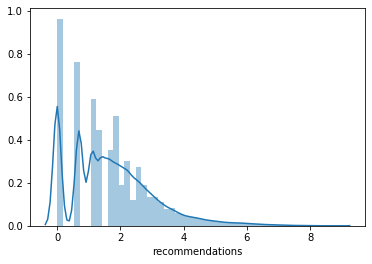

In [11]:
sns.distplot(np.log(Data_train.recommendations+1))

Scatter plot for recommendations vs articleWordCount

Text(0, 0.5, 'recommendations')

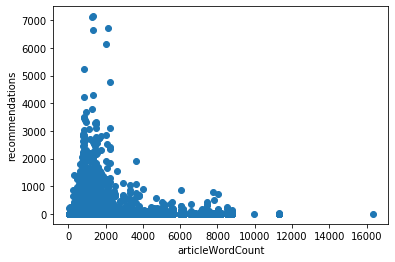

In [12]:
plt.scatter( y="recommendations", x="articleWordCount",data=Data_train, linestyle='-', marker='o')
plt.xlabel('articleWordCount')
plt.ylabel('recommendations')

Above graph shows  that  comments  on  the  longer  articles  were  lesser  recommended  probably  because  the
articles weren’t read by many and similarly for the very short articles, the recommendations were
fewer.  But it peaked for the articles with word count in the range of 500-2000 and thus, this could
be a good feature to have

Scatter plot for recommendations vs createDate

(0, 100000)

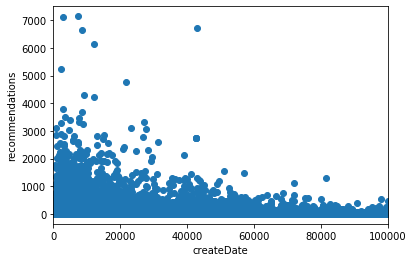

In [13]:
plt.scatter( y="recommendations", x="createDate",data=Data_train, linestyle='-', marker='o') ####
plt.xlabel('createDate')
plt.ylabel('recommendations')
plt.xlim(0,100000)

  We can see in the above graph that the highly recommended comments are generally the ones which are posted earlier. 

Scatter plot for Recommendation Vs Sentiment Score

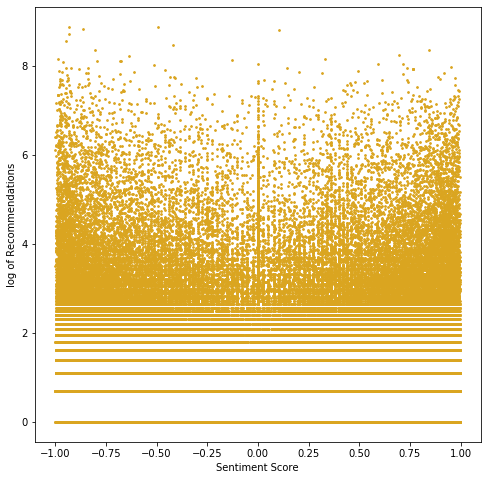

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.scatter(Data_train['Sentiment'],np.log1p(Data_train['recommendations']) ,marker='o', s=3, c="goldenrod", alpha=1)
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('log of Recommendations')
plt.show()

In [6]:
## Visyalizing the LDA model

import pickle
file=open("./pickle_file/visModel", "rb")
vis=pickle.load(file)

pyLDAvis.display(vis)


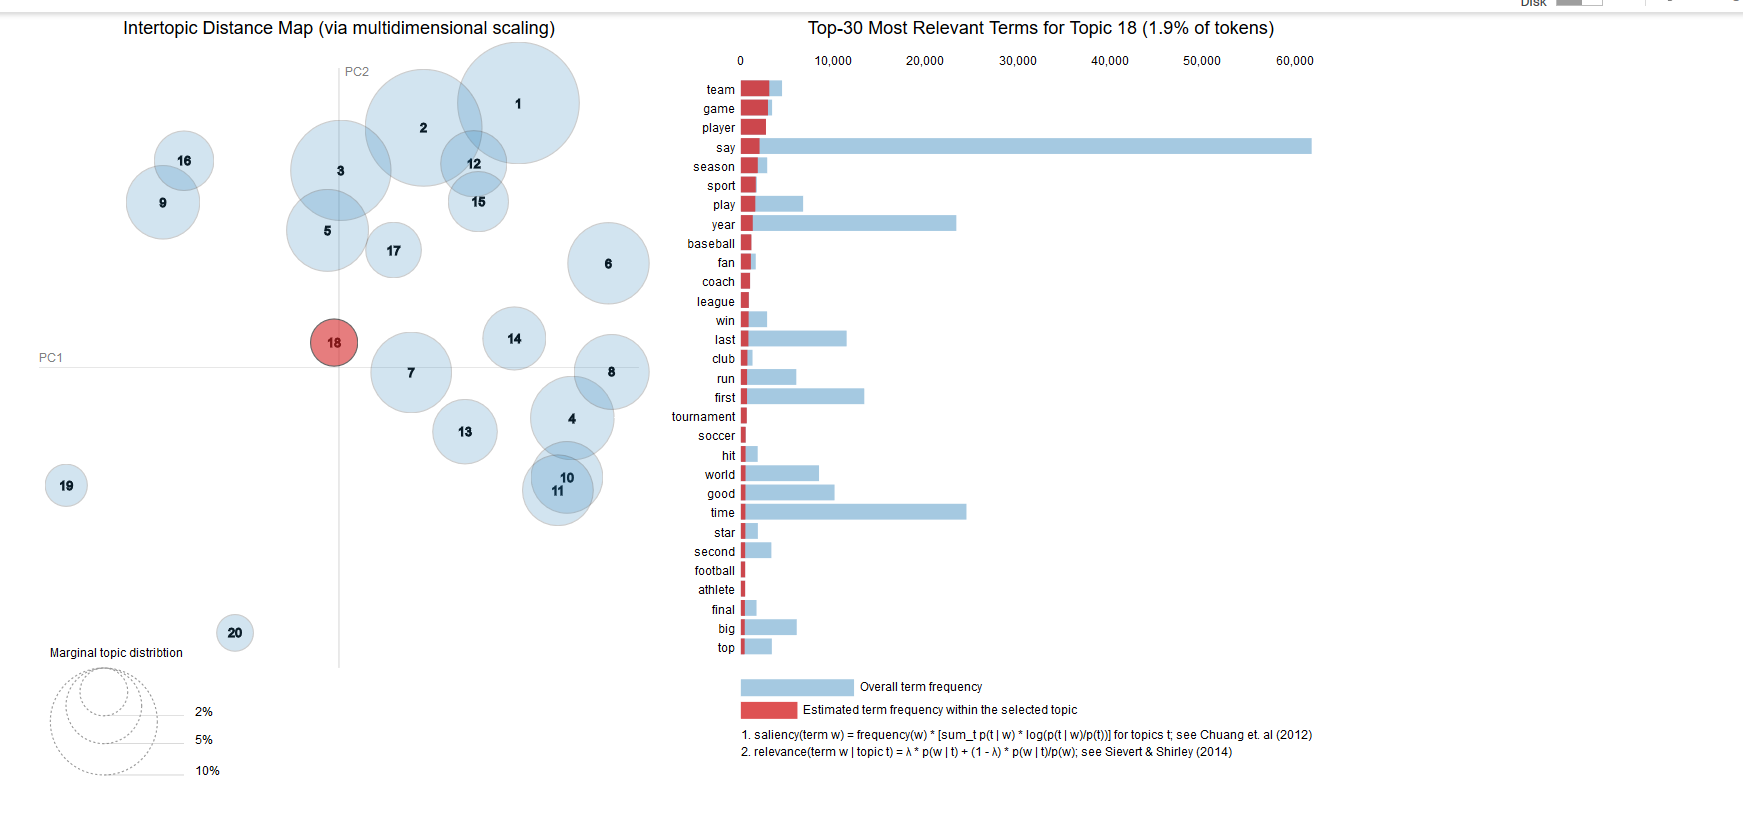

The bubbles represent the distribution of topics in the latent space and the bar graph on the right shows the distribution of the word in the selected topic.

For the interactive model, run the first cell of imports to install pyLDAvis and then run the cell above to load the pickle file and display the model.

In [0]:

#Prepare training sets
Y_train = np.log1p(Data_train['recommendations']) #take the log of our target y 
#we still haven't dropped 'recommendations' since we want to look at its correlation between features
Xtrain = Data_train.drop(['commentID','articleID'], axis=1) 
#test and validation set
Y_validate = np.log1p(Data_test['recommendations'] ) #take the log of our target y 
X_validate = Data_test.drop(['commentID','recommendations','articleID'], axis=1)
Y_test = np.log1p(Data_test['recommendations'] ) #take the log of our target y 
X_test = Data_test.drop(['commentID','recommendations','articleID'], axis=1)

Let's take a look at correlations among the features and our label y, recommendations. We use Kendall Tau correlation coefficients, which are non-parametric, rather than pearson correlation coefficients which are parametic and meaure linear correlations. 

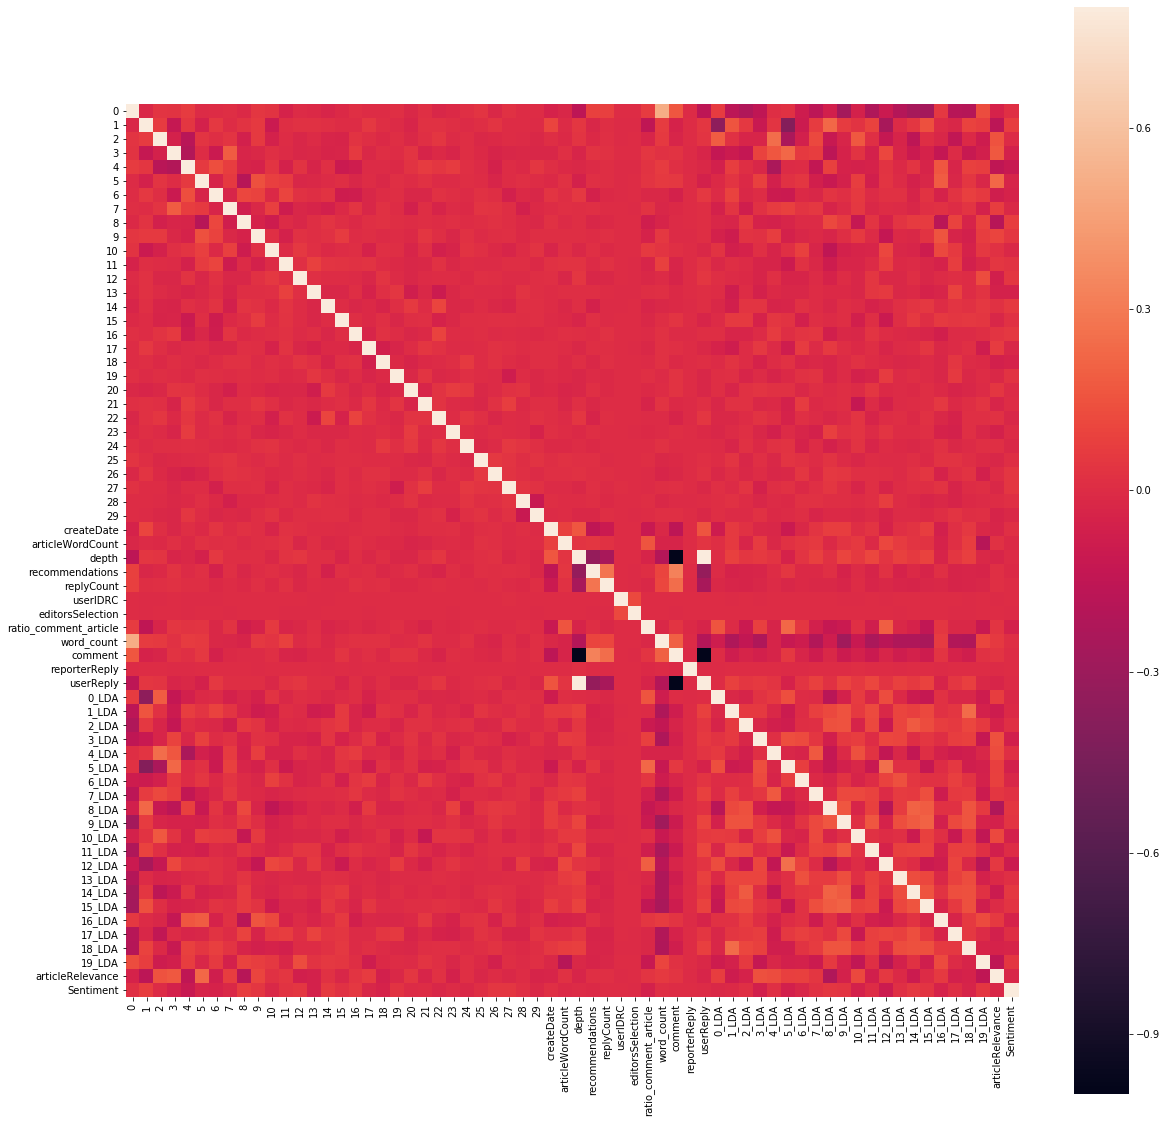

In [19]:
C_mat = Xtrain.corr(method = 'kendall')
fig = plt.figure(figsize = (20,20))
sb.heatmap(C_mat, vmax = 0.8, square = True)
plt.show()

According to the correlation heatmap, the majority of the features are not useful in predicting the target recommendation. Only a handful of features such as 'depth'(negative), 'word_count'(positive), and 'createDate'(negative) have significant correlations with the target. We therefore perform feature selection to filter out irrelevant features that would otherwise hinder our prediction. 

In [25]:
#Remove features with variance lower than 0.1
Xtrain = Data_train.drop(['recommendations' , 'commentID', 'articleID'], axis=1) 
initial_feats = np.array(Xtrain.keys())

print("The number of features of training data BEFORE feature selection: {}".format(Xtrain.shape[1]))
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(Xtrain)
indices_feats_to_remove = np.argwhere(sel.variances_ < 0.1)
feats_to_remove = [str(i[0])for i in initial_feats[indices_feats_to_remove]]
feats_remaining = np.delete(initial_feats, indices_feats_to_remove)
print("The number of features of training data AFTER feature selection: {}".format(len(feats_remaining)))
print("The remaining features after selection are: {}".format(feats_remaining))
Xtrain = Data_train.drop(feats_to_remove + ['recommendations' , 'commentID', 'articleID'], axis=1) 
Xvalidate = Data_test.drop(feats_to_remove + ['recommendations' , 'commentID', 'articleID'], axis=1)
# Xtest = Data_test.drop(feats_to_remove + ['recommendations' , 'commentID', 'articleID'], axis=1)
Xtrain.head()

The number of features of training data BEFORE feature selection: 63
The number of features of training data AFTER feature selection: 10
The remaining features after selection are: ['createDate' 'articleWordCount' 'depth' 'replyCount' 'userIDRC'
 'ratio_comment_article' 'word_count' 'comment' 'userReply' 'Sentiment']


,createDate,articleWordCount,depth,replyCount,userIDRC,ratio_comment_article,word_count,comment,userReply,Sentiment
0,9070.0,1254.0,1.0,0.0,0.000000,592.000000,327.0,1.0,0.0,0.4767
1,52691.0,1233.0,2.0,0.0,44.684211,12.523810,149.0,0.0,1.0,0.8176
2,67493.0,3637.0,1.0,0.0,33.400000,241.000000,197.0,1.0,0.0,-0.8568
3,153562.0,999.0,1.0,5.0,6.500000,14.571429,1426.0,1.0,0.0,0.9696
4,35174.0,810.0,2.0,0.0,16.000000,15.800000,762.0,0.0,1.0,0.9913


It turns out that most of the remaining features are those with significant positive or negative correlation 
coefficients in the heatmap above. However, the first selection we just performed was based on variance thresholding, not on any measure of feature-target relevance. We will now perform another feature selection using univariate selection method.

In [26]:
fscores, pvalues = f_regression(Xtrain, Y_train)
#The closer a feature's pvalue to 0.00 is, the more significance the feature is
maxindx = np.where(pvalues >= 0.25) 
minindx = np.where(pvalues < 0.25) 
remaining_feats = list(Xtrain.keys()[minindx]) #choose 8/10 most significant features
feats_to_remove = list(Xtrain.keys()[maxindx])
X_train = Xtrain.drop(feats_to_remove,axis = 1)
X_validate = Xvalidate.drop(feats_to_remove,axis = 1)
# X_test = Xtest.drop(feats_to_remove,axis = 1)
print("The remaining significant features are {}".format(remaining_feats))
X_validate.head()

The remaining significant features are ['createDate', 'articleWordCount', 'depth', 'replyCount', 'userIDRC', 'word_count', 'comment', 'userReply', 'Sentiment']


,createDate,articleWordCount,depth,replyCount,userIDRC,word_count,comment,userReply,Sentiment
0,11344.0,127.0,1.0,0.0,0.0,310,1,0,-0.6898
1,35904.0,847.0,1.0,3.0,0.0,477,1,0,-0.9082
2,29285.0,1043.0,1.0,1.0,0.0,54,1,0,0.0000
3,25297.0,2241.0,1.0,5.0,0.0,294,1,0,0.2247
4,6641.0,1081.0,1.0,2.0,0.0,343,1,0,-0.7906


Let's take a look at the correlation heatmap after our final feature selection.

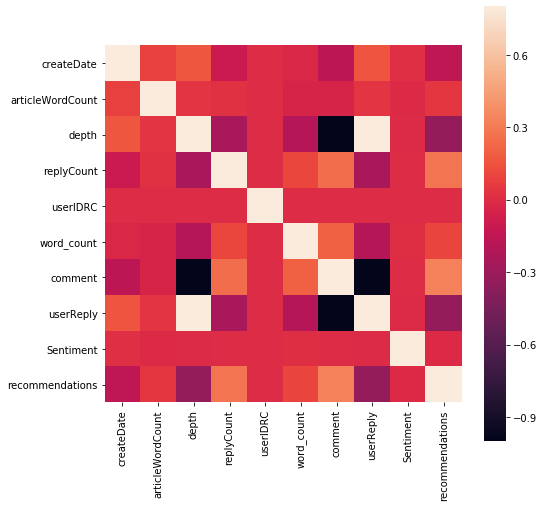

Index(['createDate', 'articleWordCount', 'depth', 'replyCount', 'userIDRC',
       'word_count', 'comment', 'userReply', 'Sentiment'],
      dtype='object')


In [22]:
X_train['recommendations'] = Y_train #add recommendation targets to the plot, will need to drop later
C_mat = X_train.corr(method = 'kendall')
fig = plt.figure(figsize = (8,8))
sb.heatmap(C_mat, vmax = 0.8, square = True)
X_train = X_train.drop(['recommendations'],axis = 1)
plt.show()
print(X_train.keys())

We now are ready to build models for recommendation prediction! Since, our training data is highly non-linear, the first method we will experiment with is K-Nearest Neighbor regression. 

In [27]:
Ks = [2, 3, 5, 10, 15, 20, 50, 100, 150, 200, 300]
validate_MAEs = []

for k in Ks:
    nays = KNeighborsRegressor(n_neighbors= k, weights = 'distance')
    #fit data to model
    nays.fit(X_train, Y_train)
    #make validation predictions
    Yval_preds = nays.predict(X_validate)
    val_err = MAE(Yval_preds, Y_validate)
    validate_MAEs.append(val_err)
    print("k:{}  || MAE: {}".format(k,val_err)) 

k:2  || MAE: 1.1987489486050908
k:3  || MAE: 1.1427002338781087
k:5  || MAE: 1.0905827415415033
k:10  || MAE: 1.0467241934684344
k:15  || MAE: 1.0330400042313164
k:20  || MAE: 1.0265537241908518
k:50  || MAE: 1.01436135561947
k:100  || MAE: 1.0121906056101135
k:150  || MAE: 1.0116034522151631
k:200  || MAE: 1.0117214081583767
k:300  || MAE: 1.0119603784251803


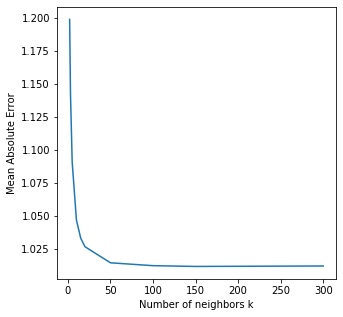

In [28]:
fig = plt.figure(figsize = (5,5))
ax = plt.axes()
plt.xlabel("Number of neighbors k")
plt.ylabel("Mean Absolute Error")

ax.plot(Ks, validate_MAEs)
plt.show()

In the plot above, the optimal k appears to be around k = 150. With a mean absolute error of 1.0054. We now turn to another model form: Ridge Regression. 


 The weights of regression are: [1.78559717e-06 1.02128345e-04 3.38393291e-01 1.27193716e-01
 1.94093566e-04 2.01996746e-04 6.85835124e-02 5.46973478e-01
 2.13022920e-02] 

The list of features corresponding to weights ordered from least magnitude to most magnitude: ['createDate', 'articleWordCount', 'userIDRC', 'word_count', 'Sentiment', 'comment', 'replyCount', 'depth', 'userReply']


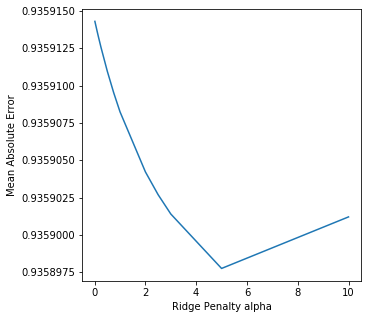

In [29]:
from sklearn.linear_model import Ridge
alphas = [0.01, 0.1, 0.15,  0.25, 0.5, 0.75, 1.0, 2.0, 2.5, 3.0, 5.0, 10.0]
regression_errs = []
for a in alphas:
    reg = Ridge(alpha = a).fit(X_train, Y_train)

    #validate error
    Y_preds_linRegress = reg.predict(X_validate)
    err = MAE(Y_preds_linRegress, Y_validate)
    regression_errs.append(err)
#     print("penalty factor: {} || MAE:{}".format(a, err))
fig = plt.figure(figsize = (5,5))
ax = plt.axes()
plt.xlabel("Ridge Penalty alpha")
plt.ylabel("Mean Absolute Error");
ax.plot(alphas, regression_errs);

print("\n The weights of regression are: {} \n".format(np.abs(reg.coef_)))
print("The list of features corresponding to weights ordered from least magnitude to most magnitude: {}".format([i for i in X_train.keys()[np.argsort(np.abs(reg.coef_))]]))


Unfortunately, as seen in the plot, the penalty factor alpha has negligible effects on the error of validation set. But the MAE from ridge regression, 0.924, is slightly lower than that from KNN Regression, 1.0054. Let's see how a simple tree regression model performs.

In [0]:
from sklearn.tree import DecisionTreeRegressor

rng = np.random.RandomState(10)
depths = np.linspace(1,15, 15)
tree_errs_validate = []
tree_errs_train = []
feat_importance_list = []
for d in depths:    
    regr_tree = DecisionTreeRegressor(max_depth=d, random_state = rng)
    regr_tree.fit(X_train, Y_train)
    y_train_preds = regr_tree.predict(X_train)
    train_err = MAE(y_train_preds,  Y_train )
#     print("depth: {}, training MAE: {}".format(d, train_err))
    y_pred = regr_tree.predict(X_validate)
    validate_err = MAE(y_pred,  Y_validate )
    tree_errs_validate.append(validate_err)
    tree_errs_train.append(train_err)
#     print("     depth: {}, validation MAE: {}".format(d, validate_err))
    feat_importance_list.append(regr_tree.feature_importances_)    

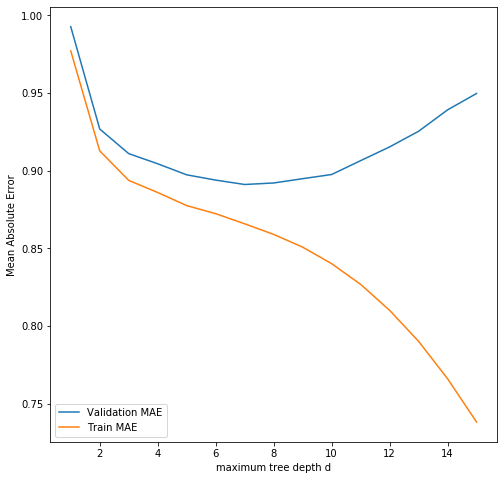

In [31]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes()
plt.xlabel("maximum tree depth d")
plt.ylabel("Mean Absolute Error")

ax.plot(depths, tree_errs_validate)
ax.plot(depths,tree_errs_train )
plt.legend(['Validation MAE', 'Train MAE'], loc='lower left')
plt.show()

In [32]:
feature_importances = feat_importance_list[np.argmin(tree_errs_validate)]
optimal_err = np.min(tree_errs_validate)
optimal_depth = np.argmin(tree_errs_validate)+1
print("Optimal tree depth: {} ==> MAE:{} \nFeatures ordered by increasing importance: \n    {}".format(optimal_depth,optimal_err, X_train.keys()[np.argsort(feature_importances)]))


Optimal tree depth: 7 ==> MAE:0.891143096410923 
Features ordered by increasing importance: 
    Index(['Sentiment', 'userIDRC', 'comment', 'depth', 'word_count',
       'articleWordCount', 'createDate', 'userReply', 'replyCount'],
      dtype='object')


An validation MAE of 0.884 from decision tree regression is the best error rate we have achieved so far. 
This suggests that a tree-based ensemble method may lead to a better performance.

Next we further tried numerous Tree based boosting models to improve the results.
Following we have mentioned some of the approaches we tried and best performing models that we got.


In [0]:
#  Creating the datset for Boosting
y=Data_train['recommendations']
X=Data_train.drop(['recommendations','articleID','commentID'],axis=1)

y_test=Data_test['recommendations']
X_test=Data_test.drop(['recommendations','articleID','commentID'],axis=1)

y_log = np.log(y+1)
y_log_test = np.log(y_test+1)



### Ensembling : 
Converting the given problem to Classification by predicting 0 and 1 based on the median ( 0 being lower than the median and 1 being greater than it). Next we apply regression on the two classes to predict the actual log of recommendation values.

We have used Random forest Classifier for the Binary Classifcation and Random Forest Regressor for further predicting log(recommendation) values. We have performed Grid Search on all the three models to select the best hyper parameters.

In [0]:
# Creating classifiction target values based on the median of the recommendation i.e 3
yc = (y>3)*1
yc_test = (y_test>3)*1


In [35]:
param_grid = {
    'max_depth': [10,20, 50],
    'max_features': [None, 'log2'],
    'max_leaf_nodes':[50,60],
    'n_estimators': [100]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 10)
grid_search.fit(X, yc)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 73.9min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 84.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [36]:
## Best Parameters obtained for Random Forest Classifier
grid_search.best_params_

{'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': 60,
 'n_estimators': 100}

In [37]:
### Accuracies on Train and Validation set for Random Forest Classifier
print("accuracy on train set",accuracy_score(yc, grid_search.predict(X)))
print("accuracy on Validation set",accuracy_score(yc_test, grid_search.predict(X_test)))

accuracy on train set 0.6912575315301573
accuracy on Validation set 0.6742717323016897


In [0]:
# Saving the predicted output which will be used further for dividing data into classifixation and regression
X['classified']=grid_search.predict(X)
X_test['classified']=grid_search.predict(X_test)


In [0]:
# Creating separate Xs and ys for using Regression on them
X1 = X[X['classified']==1]
X0 = X[X['classified']==0]
X1_test = X_test[X_test['classified']==1]
X0_test = X_test[X_test['classified']==0]
y1 = y_log[X['classified']==1]
y0 = y_log[X['classified']==0]
y1_test = y_log_test[X_test['classified']==1]
y0_test = y_log_test[X_test['classified']==0]



In [41]:
# Running regression model on the outputs predicted belonging to class 1 to further predict the log of recommendation values.

param_grid = {
    'max_depth': [10,20, 50, 80],
    'max_features': [None, 'log2'],
    'max_leaf_nodes':[50,60],   #grid_search
    'n_estimators': [100]
}# Create a based mode
rf = RandomForestRegressor()# Instantiate the grid search model
grid_search_reg1 = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search_reg1.fit(X1,y1)
y1_pred = grid_search_reg1.predict(X1_test)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 58.5min finished


In [42]:
## Best Parameters obtained for Random Forest Regressor for the results classified as belonging to class 1
grid_search_reg1.best_params_

{'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 60,
 'n_estimators': 100}

In [43]:

### MAE on Validation for Random Forest Regressor
mae1_train=mean_absolute_error(grid_search_reg1.predict(X1),y1)
mae1_test = mean_absolute_error(y1_pred,y1_test)
print("MAE on Train set",mae1_train)
print("MAE on Validation set",mae1_test)


MAE on Train set 0.9302393634487216
MAE on Validation set 0.9790655786614207


In [45]:
# Running regression model on the outputs predicted belonging to class 0 to further predict the log of recommendation values.
param_grid = {
    'max_depth': [10,20, 50, 80],
    'max_features': [None, 'log2'],
    'max_leaf_nodes':[50,60],
    'n_estimators': [100]
}# Create a based mode
rf = RandomForestRegressor()# Instantiate the grid search model
grid_search_reg0 = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search_reg0.fit(X0,y0)
y0_pred = grid_search_reg0.predict(X0_test)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 32.3min finished


In [46]:
## Best Parameters obtained for Random Forest Regressor for the results classified as belonging to class 0
grid_search_reg0.best_params_

{'max_depth': 80,
 'max_features': None,
 'max_leaf_nodes': 60,
 'n_estimators': 100}

In [47]:
### MAE on Validation for Random Forest Regressor
mae0_train=mean_absolute_error(grid_search_reg0.predict(X0),y0)
mae0_test = mean_absolute_error(y0_pred,y0_test)
print("MAE on Train set",mae0_train)
print("MAE on Validation set",mae0_test)

MAE on Train set 0.6727655052924568
MAE on Validation set 0.7438951686236451


In [48]:
# Averaging the two MAE's for both the classes and getting the final MAE value
mae_net_train=(y1.shape[0]*mae1_train + y0.shape[0]*mae0_train)/(y1.shape[0] + y0.shape[0])
mae_net_test=(y1_test.shape[0]*mae1_test + y0_test.shape[0]*mae0_test)/(y1_test.shape[0] + y0_test.shape[0])
print("Combined total MAE on Train set",mae_net_train)
print("Combined total MAE on Validation set",mae_net_test)

Combined total MAE on Train set 0.8363271987211154
Combined total MAE on Validation set 0.8944312916247131


Predicting on the Heldout Test set

In [70]:
TEST = pd.read_csv("./Final_data/UNSEEN_TESTING_DATA.csv")
y_test_fin=TEST['recommendations']
X_test_fin=TEST.drop(['recommendations','articleID','commentID'],axis=1)
y_log_test_fin=np.log(y_test_fin+1)
yc_test_ho = (y_test_fin>3)*1

print("1st stage Classification accuracy on heldout test set",accuracy_score(yc_test_ho, grid_search.predict(X_test_fin)))
X_test_fin['classified']=grid_search.predict(X_test_fin)

X1_ho = X_test_fin[X_test_fin['classified']==1]
X0_ho = X_test_fin[X_test_fin['classified']==0]
y1_ho= y_log_test_fin[X_test_fin['classified']==1]
y0_ho= y_log_test_fin[X_test_fin['classified']==0]

y1_pred_ho= grid_search_reg1.predict(X1_ho)
mae1_test_ho = mean_absolute_error(y1_pred_ho,y1_ho)
print("MAE on heldout test set for class 1",mae1_test_ho)

y0_pred_ho= grid_search_reg0.predict(X0_ho)
mae0_test_ho = mean_absolute_error(y0_pred_ho,y0_ho)
print("MAE on heldout test set for class 0",mae0_test_ho)

mae_net_test_ho=(y1_ho.shape[0]*mae1_test_ho + y0_ho.shape[0]*mae0_test_ho)/(y1_ho.shape[0] + y0_ho.shape[0])
print("Combined total MAE on heldout test set",mae_net_test_ho)

1st stage Classification accuracy on heldout test set 0.6771649637932745
MAE on heldout test set for class 1 0.9627828316889677
MAE on heldout test set for class 0 0.7392380966907168
Combined total MAE on heldout test set 0.8826872476384089


The MAE on the Validation set obtained for the above 2 step model was 0.89, which is not the best so far and can be further improved. Therefore we further tried some more ensembling techniques.

In [0]:
X.drop(['classified'],axis=1,inplace=True)
X_test.drop(['classified'],axis=1,inplace=True)

#### XGBoosting

In [62]:
##  Training the XGB model
XGB_=xgb.XGBRegressor(max_depth= 10, eta= 0.4,eval_metric='mae',subsample=0.5)
eval_set = [(X, y_log), (X_test, y_log_test)]
XGB_.fit(X, y_log, early_stopping_rounds=5, eval_metric=['mae'], eval_set=eval_set, verbose=True)

[00:04:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1.27134	validation_1-mae:1.27327
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:1.19019	validation_1-mae:1.20179
[2]	validation_0-mae:1.12506	validation_1-mae:1.14406
[3]	validation_0-mae:1.06858	validation_1-mae:1.0952
[4]	validation_0-mae:1.01978	validation_1-mae:1.05336
[5]	validation_0-mae:0.979355	validation_1-mae:1.01934
[6]	validation_0-mae:0.945498	validation_1-mae:0.994612
[7]	validation_0-mae:0.917291	validation_1-mae:0.972209
[8]	validation_0-mae:0.894258	validation_1-mae:0.953545
[9]	validation_0-mae:0.874013	validation_1-mae:0.938897
[10]	validation_0-mae:0.85695	validation_1-mae:0.926289
[11]	validation_0-mae:0.842533	validation_1-mae:0.917073
[12]	validation_0-mae:0.830792	validation_1-mae:0.908925

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.4, eval_metric='mae',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.5, verbosity=1)

Above we can see that the MAE on train and validation data are continuously decreasing. This suggests that model has learned data and is able to perform well on validation.

In [63]:
### Printing the results of validation set
ypred = XGB_.predict(X_test)
mean_absolute_error(ypred,y_log_test)

0.8787174779038688

Below are 25 important features plotted and their respective feature importances. Numberical features are those of TF-IDF performed on the comments. We can see that they have highest feature importances.  Also, a few LDA features, sentiments, word counts of articles etc also have contributed significantly in predicting the outcome.

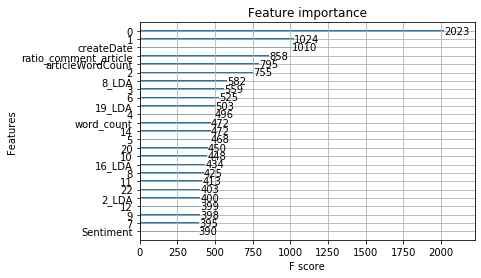

In [64]:
## Plotting the feature importances.
plot_importance(XGB_,height = 0.2,max_num_features=25)

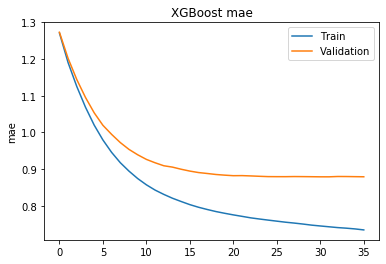

In [65]:
from matplotlib import pyplot
results = XGB_.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Validation')
ax.legend()
pyplot.ylabel('mae')
pyplot.title('XGBoost mae')
pyplot.show()


In the above Plot of MAE vs Epochs on Train and Validation. We can see that they are continuously decreasing and results stabalize towards the end suggesting that model has converged


Also, we have got the MAE of 0.8787 on the Validation set, which was the best performing model by far.  We were not able to further decrease this MAE by other ensembling Techniques.

#### Auto Sklearn Results

Lastly, we also tried Regression using Auto Sklearn on 5000 randomly sampled data points. It gave an MAE of 0.88. 

The code took a long time to run (approx 6hrs). Therefore, we were not able to run it again on the final norebook. We are posting image of the results.
 
![](https://drive.google.com/uc?export=view&id=1IjmBuNQl7zQMSnNdVT_fPOto5agD41Jt)

![](https://drive.google.com/uc?export=view&id=1etOBYEtKBpkXR19K0DXt-VTcBYN65-jl)



##### Final Results

Finally we can conclude that XGboost was giving the lowest MAE and was the best performing model that we got.


Further using the selected model to find the accuracy of the unseen test set

In [0]:
TEST = pd.read_csv("./Final_data/UNSEEN_TESTING_DATA.csv")
y_test_fin=TEST['recommendations']
X_test_fin=TEST.drop(['recommendations','articleID','commentID'],axis=1)
y_log_test_fin=np.log(y_test_fin+1)


In [68]:

ypred = XGB_.predict(X_test_fin)
mean_absolute_error(ypred,y_log_test_fin)

0.8641138109046761

We can see that Test and Validation MAEs are not too far from each other. Therefore, we can conclude that model is generalized and will perform well on a new unseen dataset. 

In [0]:
## Saving the Final Model
with open("./pickle_file/FinalXGBModel", 'wb') as file:
    pickle.dump(XGB_, file)

As we saw before, fitting a simple decision tree performed really well and thus, the idea of using ensemble of trees with boosting spiked up. As expected, the XGBoost tree boosting algorithm worked the best for us evidently. This was because it was able to capture the non-linearities of the feature space better than most and boosting further helped improve the performance of the ensemble of trees.  

Further detailed results and conclusion for all other models can be found in submitted  report.